In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from Network import *
from Task import *
from HelperFunctions import *
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import scipy.interpolate
import numpy as np

device = None

In [2]:
task = 'trace' #'trace_search' 'search_trace' #'trace'
curve_length = 6
grid_size = 6

# Behaviour of the network

## Performance

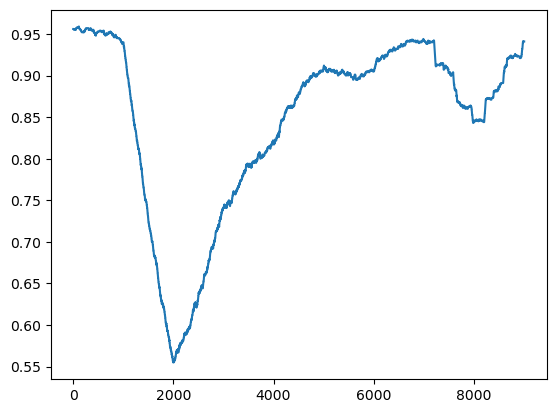

In [3]:
performance = np.load(os.path.join('results','performance_'+task+'_'+str(curve_length)+'.npy'))

plt.figure()
plt.plot(np.convolve(performance, np.ones(1000), 'valid') / 1000)

## Generalization

(0.5, 1.0)

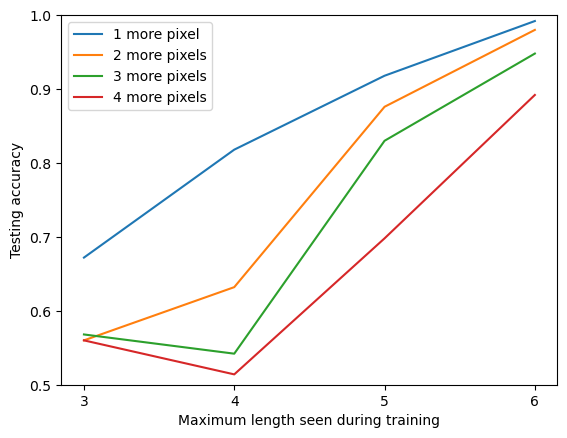

In [4]:
generalisation = np.load(os.path.join('results','generalisation_'+task+'_'+str(curve_length)+'.npy'))

plt.plot(np.diag(generalisation,0))
plt.plot(np.diag(generalisation,1))
plt.plot(np.diag(generalisation,2))
plt.plot(np.diag(generalisation,3))


plt.legend(['1 more pixel','2 more pixels','3 more pixels','4 more pixels'])
plt.xlabel('Maximum length seen during training')
plt.xticks([i for i in range(curve_length-2)],[i for i in range(3,curve_length+1)])
plt.ylabel('Testing accuracy')
plt.ylim([0.5,1])


## Results

In [4]:
neural_activations = open_base(os.path.join('results','network_activations_'+task+'_'+str(curve_length)))


target_activations_recurrent = neural_activations['target_activations'][0][:,:3,:,:,:]
distractor_activations_recurrent = neural_activations['distractor_activations'][0][:,:3,:,:,:]

target_activations_feedforward = neural_activations['target_activations'][0][:,3,:,:,:]
distractor_activations_feedforward = neural_activations['distractor_activations'][0][:,3,:,:,:]

target_activations_output = neural_activations['target_activations'][0][:,4,:,:,:]
distractor_activations_output = neural_activations['distractor_activations'][0][:,4,:,:,:]

### Timecourse of modulation

#### Recurrent layers

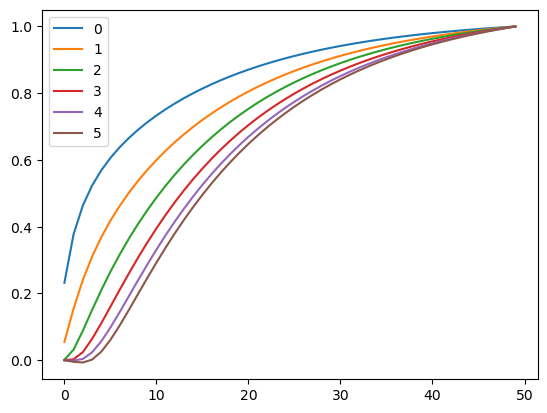

In [5]:
plt.figure()
TD = target_activations_recurrent - distractor_activations_recurrent

normalized_TD = np.nanmean(TD,axis = (0,1,2))
normalized_TD = normalized_TD/np.expand_dims(np.max(normalized_TD,axis = 1),axis = 1)
plt.plot(normalized_TD.T)

legend = [str(i) for i in range(curve_length)]
if task != 'trace':
    legend.append('marker')
plt.legend(legend)



#### Output layer

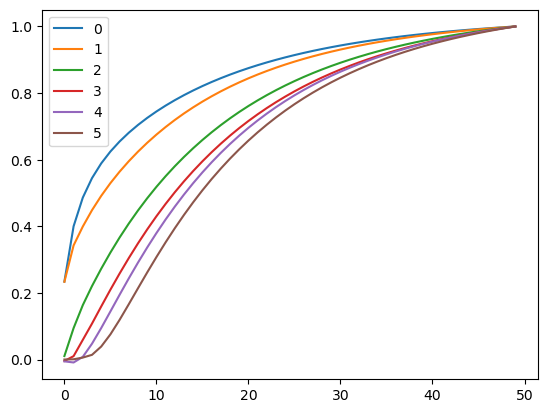

In [6]:
plt.figure()
TD = target_activations_output - distractor_activations_output

normalized_TD = np.nanmean(TD,axis = (0,1))
normalized_TD = normalized_TD/np.expand_dims(np.max(normalized_TD,axis = 1),axis = 1)
plt.plot(normalized_TD.T)

legend = [str(i) for i in range(curve_length)]
if task != 'trace':
    legend.append('marker')
plt.legend(legend)


### Individual pixel

In [19]:
target_activations_recurrent.shape

(38, 3, 4, 7, 50)

(0.0, 0.5)

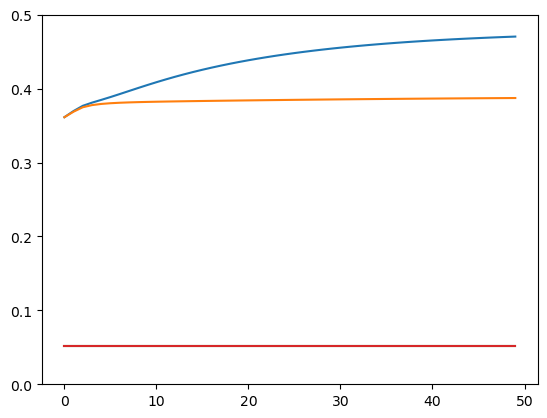

In [20]:

neuron_number = 25
recurrent_layer_number = 1
feature_number = 0
neuron_position_on_curve = 5

plt.plot(target_activations_recurrent[neuron_number,recurrent_layer_number,feature_number,neuron_position_on_curve,:])
plt.plot(distractor_activations_recurrent[neuron_number,recurrent_layer_number,feature_number,neuron_position_on_curve,:])
plt.plot(target_activations_feedforward[neuron_number,feature_number,neuron_position_on_curve,:])
plt.plot(distractor_activations_feedforward[neuron_number,feature_number,neuron_position_on_curve,:])
plt.ylim([0,0.5])

### Sign of modulation

(array([0.15051998, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01094691,
        0.19704433, 0.02736727, 0.12041598, 0.35851122, 0.40229885,
        0.43240285, 0.3667214 , 0.63765736, 0.96059113, 1.33552271]),
 array([-2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,
         0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <BarContainer object of 20 artists>)

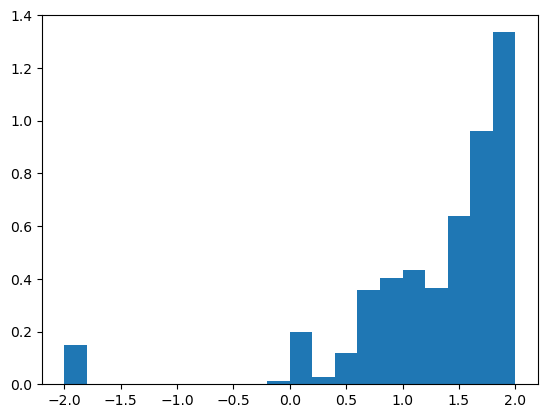

In [7]:
modulation = (target_activations_recurrent - distractor_activations_recurrent) / ((target_activations_recurrent + distractor_activations_recurrent) / 2)

dprime = modulation[:,:,:,:,-1].flatten()
plt.hist(dprime,density=True,bins=20)


### Cumulative modulation latency at individual recording sites

2
4


Text(0.5, 0, 'Modulation latency')

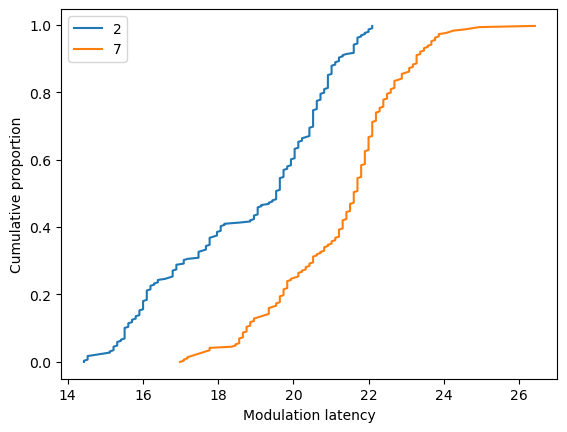

In [12]:
if task == 'trace':
    operation_1 = operation_2 = 'trace'
else:
    operation_1 = 'trace'
    operation_2 = 'search'


TD = target_activations_recurrent - distractor_activations_recurrent


timesteps_1 = latency_operation(TD,operation_1,task,curve_length,criterion=0.7,dur = 50,position_on_curve = 2)
X_1 = np.sort(timesteps_1)
F_1 = np.array(range(len(timesteps_1)))/float(len(timesteps_1))

timesteps_2 = latency_operation(TD,operation_2,task,curve_length,criterion=0.7,dur=50,position_on_curve = curve_length-2)
X_2 = np.sort(timesteps_2)
F_2 = np.array(range(len(timesteps_2)))/float(len(timesteps_2))

plt.plot(X_1, F_1)
plt.plot(X_2, F_2)
if task == 'trace':
    plt.legend(['2','7'])
else:
    plt.legend([operation_1,operation_2])
plt.ylabel('Cumulative proportion')
plt.xlabel('Modulation latency')


# Accessory network learning (only for trace task)

In [17]:
with open(os.path.join('results','network_'+task+'_'+str(6)+'.pkl'), 'rb') as pickle_file:
    n = pickle.load(pickle_file)

n.save_activities = False
n.exploitation_probability = 1
    
timesteps = 40
trial_number = 50

# Fig. 4B, left
curve_length_accessory = curve_length

# Fig. 4B, right
#curve_length_accessory = curve_length + 5

target_activations_accessory = np.zeros((timesteps,curve_length_accessory,trial_number)) #accessory timesteps, curvelength, trials
distractor_activations_accessory = np.zeros((timesteps,curve_length_accessory,trial_number))


trial = 0
while trial < trial_number:
    if task == 'trace':
        t=Trace(4,grid_size)
    elif task == 'search_trace':
        t=SearchTrace(4,grid_size)
    elif task == 'trace_search':
        t=TraceSearch(4,grid_size)
    t.no_curves = False
    t.only_trace_curve  = False
    t.curve_length = curve_length_accessory
    
    new_input, reward, trialEnd = t.do_step(0)
    target_hist = t.target_curve.copy()
    distr_hist = t.distractor_curve.copy()
    action = n.do_step(new_input,reward,trialEnd,device)
    new_input, reward, trialEnd = t.do_step(action)
    if reward == 0: #the correct curve is the target curve, works also if looking at the distractor curve (if reward == 1: continue)
        continue

    target_activations_accessory_temp,distractor_activations_accessory_temp =  compute_z(n,t,target_hist,distr_hist,grid_size,timesteps)
    target_activations_accessory[:,:,trial] = target_activations_accessory_temp
    distractor_activations_accessory[:,:,trial] = distractor_activations_accessory_temp
    trial += 1

(-1.1, 1.1)

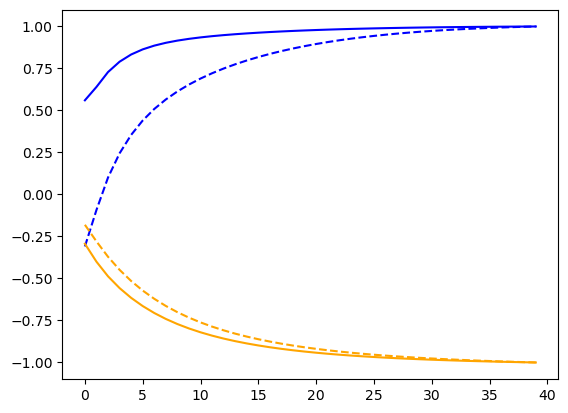

In [18]:
# Fig. 4B, left


plt.plot(np.mean(target_activations_accessory[:,curve_length - 1,:],axis=-1)/np.max(np.abs(np.mean(target_activations_accessory[:,curve_length - 1,:],axis=-1))),color='b')
plt.plot(np.mean(target_activations_accessory[:,curve_length - 3,:],axis=-1)/np.max(np.abs(np.mean(target_activations_accessory[:,curve_length - 3,:],axis=-1))),linestyle='dashed',color='b')

plt.plot(np.mean(distractor_activations_accessory[:,curve_length - 1,:],axis=-1)/np.max(np.abs(np.mean(distractor_activations_accessory[:,curve_length - 1,:],axis=-1))),color='orange')
plt.plot(np.mean(distractor_activations_accessory[:,curve_length - 3,:],axis=-1)/np.max(np.abs(np.mean(distractor_activations_accessory[:,curve_length - 3,:],axis=-1))),linestyle='dashed',color='orange')
plt.ylim([-1.1,1.1])
#plt.legend(['0','1','2','3'])


(-1.1, 1.1)

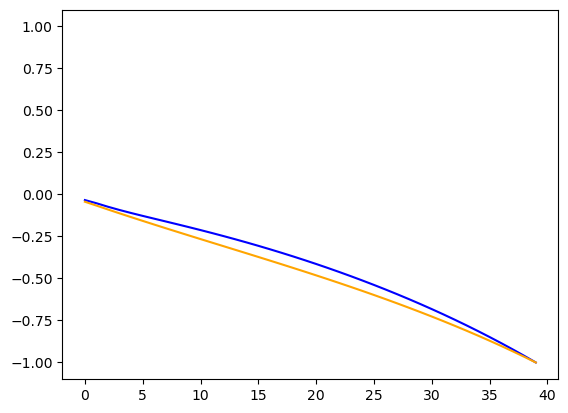

In [16]:
# Fig. 4B, right
plt.plot(np.mean(target_activations_accessory[:,curve_length - 1,:],axis=-1)/np.max(np.abs(np.mean(target_activations_accessory[:,curve_length - 1,:],axis=-1))),color='b')
plt.plot(np.mean(distractor_activations_accessory[:,curve_length - 1,:],axis=-1)/np.max(np.abs(np.mean(distractor_activations_accessory[:,curve_length - 1,:],axis=-1))),color='orange')
plt.ylim([-1.1,1.1])
#plt.legend(['0','1','2','3'])
